# <center>Extracting and Analyzing SIOP-Related Tweets</center>
_<center>Leveraging Data Science 2019 SIOP Master Tutorial</center>_



First, let's load the libraries we'll need.

In [303]:
library(tm)
library(tidyverse)
library(rtweet)
library(stringr)
library(wordcloud)
library(curl)
library(rJava)
library(RWeka)
library(tidytext)
library(koRpus)
library(caret)
library(glmnet)
library(gbm)

Next we need to set up access to the Twitter API. The Twitter API will allow us to request data from Twitter to use later in our analyses. In order to obtain permission to access the Twitter API, you'll need to first set up credentials. To do this, you'll need to log into Twitter and create an application: https://developer.twitter.com/en/account/get-started. Once you have created an application, locate your "keys and tokens." We'll temporarily save these to our local R environment. Make sure you don't share these with others!

Add your keys here:

In [304]:
# Replace these with your Twitter access keys (in the quote) - DO NOT SHARE YOUR KEYS WITH OTHERS
appname <- "SIOP Data Science Tutorial"
key <- "key"
secret <- "secretkey"
access_token <- "accesstoken"
access_secret <- "secretaccesstoken"
	
# Store these keys for the next step (just run this script)
twitter_token<- create_token(
  app = appname,
  consumer_key = key,
  consumer_secret = secret,
  access_token = access_token,
  access_secret =access_secret)


Now that we have our Twitter API credential set up, we can submit an API request. To do this we will use the R package **rtweet** (https://rtweet.info/). Using this package you can interact with Twitter's API by searching recent tweets by keywords, publishing tweets, getting trends, and even pulling entire timelines. For this demonstration, we'll be searching for tweets related to SIOP and IO psychology by searching for tweets that contain #SIOP, #IOPsych, #IamSIOP, #SIOP19. 

It's important to note that free access to Twitter's API restricts search capabilities to tweets that have occured in the past 6-9 days. Twitter also limits search results to 18,000 tweets every 15 minutes. Paid tiers provide more access and options. 

Using the **rtweets::search_tweets()**  we'll specify our search parameters using the _q_ argument and the number of tweets using the _n_ argument. We'll also save our output to a csv file. 


In [305]:
#This code is commented out because we already have our data. To uncomment, remove the # in front of the code. 

#siop_tweets <- search_tweets(q = "#SIOP OR #IOPsych OR #IamSIOP OR #SIOP19",
#                              n = 1500)
#write_as_csv(siop_tweets, "tweets.csv")

#for this demonstration, we'll just read in our saved tweets (These tweets were collected over the span of two weeks by running the above function once/week)
tweets <- read.csv("../SIOP 19 MT data science/tweets.csv")

Now we have some data! Let's check it out by clicking on the file in the "Files" tab to your left in the jupyterlab environment. 

This is pretty clean output but we'll still need to do some data cleaning depending on which parts of the data we're interested in. Let's do some exploring. 

The rtweets package has some built in visualization tools. We'll start by plotting a time series of our tweets using the **ts_plot()** function.

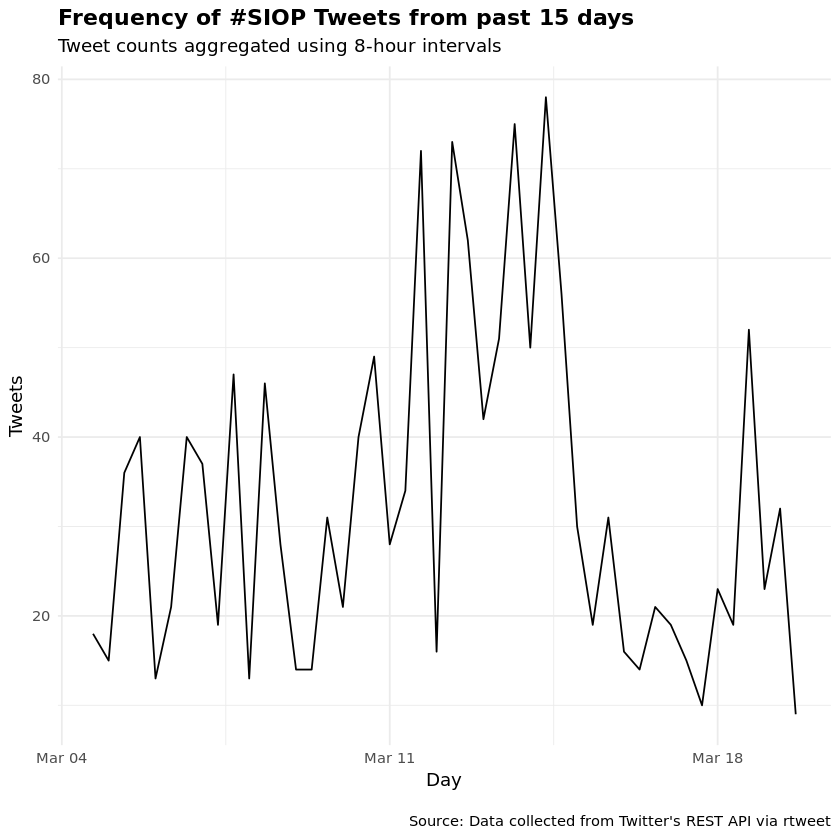

In [306]:
#First Let's specify that the tweet is in English
tweets <- tweets %>%
filter(lang == "en")

# Next, let's plot a time series of tweet frequency
ts_plot(tweets, "8 hours") +
  ggplot2::theme_minimal() +
  ggplot2::theme(plot.title = ggplot2::element_text(face = "bold")) +
  ggplot2::labs(
    x = "Day", y = "Tweets",
    title = "Frequency of #SIOP Tweets from past 15 days",
    subtitle = "Tweet counts aggregated using 8-hour intervals",
    caption = "\nSource: Data collected from Twitter's REST API via rtweet"
  )

It looks like there was an uptick in tweets sometime between March 12-14.

Now let's start to look at tweet content. This is going to require a bit of text preprocessing.

In [307]:
# Let's first drop retweets since those will provided redundant text. 
tweets_preprocessed <- tweets%>%
filter(is_retweet == FALSE)

#make sure that worked (note that only RT without added text are removed so we'll keep the ones with commentary)
table(tweets_preprocessed$is_retweet)



FALSE 
  707 

Here is the twitter text prior to pre-processing (a random sample of the dataset):

In [308]:
tweets_preprocessed %>%
mutate(text = as.character(text))%>%
select(text)%>%
sample_n(size = 10)

,text
441,"""Job Characteristics Contributing to Employee Turnover: Do Nothing and You Risk Losing People"" @ScienceForWork . #IOPsych #OrgDev https://t.co/1dGh9tRAS0"
133,Was just referring to the job characteristics literature today. This gem 💎 showed up in my feed with perfect timing #IOPsych https://t.co/GEByFaqjLX
704,My colleague @joeyweinman got back on Twitter for #ellchat_bkclub! He's been trying out using #siop in his class on his own as well. Can't wait to get rolling with our book next month! #ellchat #pln #bestpractice #teaching #tesol #esl #esol #tefl
635,"Rather than rely on single questions and percent agreement to capture topics of interest, #IOPsych uses #psychometrics to assess and evaluate psychological constructs and #statisticalanalyses to test their relationships #QuickFacts"
430,"Making the Most of SIOP as a Student https://t.co/lJTHPG7Y13 #IOPsych, #SIOP19 CC @SIOPtweets"
156,"Thousands of #IOPsych pros will share insights on the most important topics of the day at #SIOP19, April 4-6. Where will you be? Attendance is open to all. Read more about conference sessions related to the #Top10WorkplaceTrends here: https://t.co/wQpgQ1liIx https://t.co/XJTj0gGiev"
129,Looking for recommendations for a suitably qualified #IOPsych practitioner who can administer and provide feedback using the NEO PI-R big 5 personality inventory. Please reply or DM - thank you https://t.co/5EcKU2jHlJ
265,The unforeseen and unintended consequences of bans on #personality testing. https://t.co/Muj6Jh2jQP #IOPsych #HR #PsychTwitter
638,Congratulations to Dr. Beth Bynum for winning the SIOP 2019 Distinguished Early Career Contributions – Practice Award! #SIOP19 @SIOPtweets https://t.co/ytJYhAKzMR https://t.co/3jY6HsV9ia
358,"Looking at 2019/2020, what do you think are some of the growing needs in IO psychology that students will not gain inside the classroom? Will look to see how a student org can fill those gaps. #SIOP #IOpsychology"


Now we need to do some preprocessing. We'll remove URLs, retweets, hashtags, mentions, special characters, punctuation, and stopwords. 

We'll also strip white space, and convert to lowercase. 

In [309]:
#preprocess tweet test
tweets_preprocessed$text <- lapply(tweets_preprocessed$text, function(x) {

  x = gsub('http\\S+\\s*', '', x) ## Remove URLs
  x = gsub('\\b+RT', '', x) ## Remove RT
  x = gsub('#\\S+', '', x) ## Remove Hashtags
  x = gsub('@\\S+', '', x) ## Remove Mentions
  x = gsub('[[:cntrl:]]', '', x) ## Remove Controls and special characters
  x = gsub("\\d", '', x) ## Remove Controls and special characters
  x = gsub('[[:punct:]]', '', x) ## Remove Punctuations
  x = str_to_lower(x) ## convert to lowercase
  x = removeWords(x, stopwords("en")) ## remove stopwords
  x = removeWords(x, c("amp", "dont","get", "will","use")) ## remove "amp" associated with & and other words that are not meaningful in this context
  x = gsub(' +',' ',x) ## Remove extra whitespaces
  
})


Let's re-examine the text after preprocessing. 

In [310]:
tweets_preprocessed %>%
mutate(text = as.character(text))%>%
select(text)%>%
sample_n(size = 10)

,text
152,masters consortium doctoral consortium includes impressive lineup speakers offer unique perspectives mc dc held april apply now masters doctoral
90,favorite theory motivation broadly including interdisciplinary approaches go
139,excited attend siop washington dc april th learn conference gtgt
71,discussion
441,job characteristics contributing employee turnover nothing risk losing people
696,shl proud platinum sponsor siop connect us discuss future work io psychology including ai mobile assessments machine learning competencies
178,siopers amy wrzesniewski greg barnett share science behind success job performance job crafting
199,icymi podcast really good although interview intersection tech really like middle part bridging scientist practitioner gap also transcript available
222,im almost excited return
551,love animation showing occupational psychologists done society makes even prouder one


Now we need to create a corpus and convert our text into a document term matrix (rows are tweets, columns are n-grams)

In [311]:
tweets_corpus <- VCorpus(VectorSource(tweets_preprocessed$text))# Convert to corpus
Tokenizer <- function(x) NGramTokenizer(x, Weka_control(min = 1, max = 1)) # Create tokenizer function (will convert words into n-grams)
tweets_dtm <- DocumentTermMatrix(tweets_corpus, control = list(tokenize = Tokenizer)) #create a document-term-matrix
tweets_dtm <- removeSparseTerms(tweets_dtm, 0.99)# We'll also get rid of relatively unusual terms
DTM_df <- as.data.frame(as.matrix(tweets_dtm)) #finally let's convert the dtm into a dataframe
head(DTM_df)

also,amazing,annual,another,april,around,article,ask,attend,available,⋯,work,working,workplace,workshop,world,worth,year,years,youll,youre
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0


Now that our tweet text is clean, let's start to look the text a bit. We can visualize common words with a simple wordcloud.

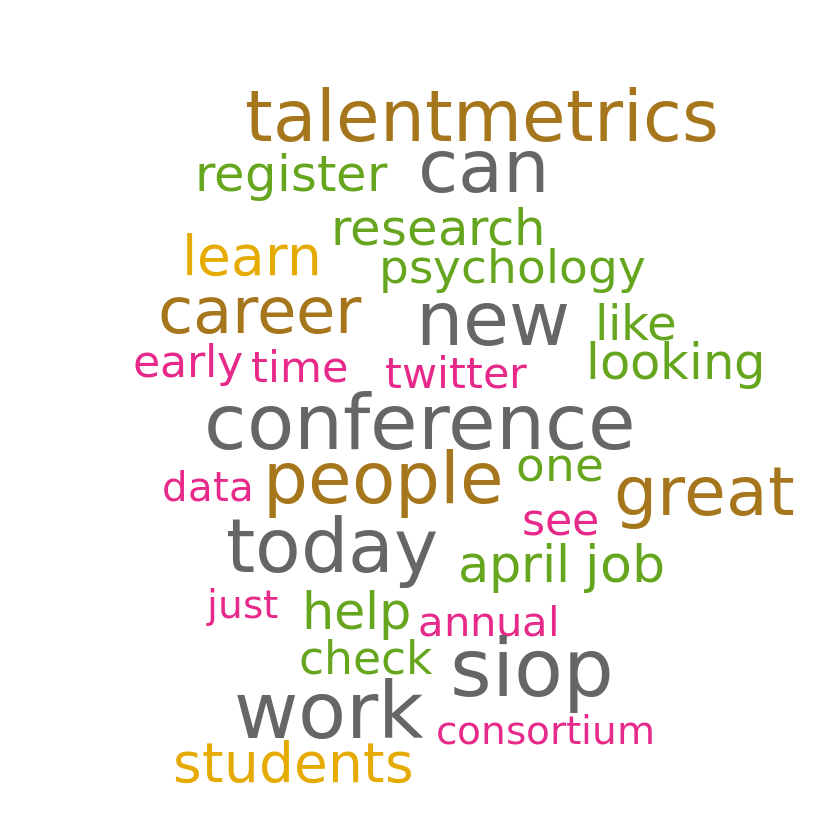

In [312]:
# Create wordcloud
wordCounts <- colSums(DTM_df)
wordNames <- names(DTM_df)
wordcloud(wordNames, wordCounts, max.words=30,, colors = brewer.pal(8, "Dark2"))

We can also look at the a list of the most frequent words

In [313]:
tibble(wordNames, wordCounts) %>% arrange(desc(wordCounts)) %>% top_n(20)

Selecting by wordCounts


wordNames,wordCounts
siop,53
work,52
conference,51
new,49
today,49
can,48
people,46
talentmetrics,46
great,44
career,41


Let's also analyze the sentiment of tweets and break down word clounds by sentiment. Perhaps we'll see what negative and positive words people are using. 

We'll use the **tidytext** package. Sentiment can be calculated in a number of ways. You can use dictionaries that assign scores to individual words (a really negative word is -5 and a really positive word is 5). You can also label individual words as positive or negative. For this example, we'll score individual words using the bing dictionary which labels words as positive or negative (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html).

Here's what the word dictionary looks like:

In [314]:
tail(get_sentiments("bing"))


word,sentiment
zealous,negative
zealously,negative
zenith,positive
zest,positive
zippy,positive
zombie,negative


In [315]:
#Prepare data for analyzing sentiment
wordlist<-tibble(wordNames, wordCounts) #create a tibble of words and counts
colnames(wordlist)<-c("word","count") #rename columns to match sentiment dictionary

# we'll map on the sentiment labels with an inner_join
# note that using an inner join will only keep words that exist in the sentiment dictionary
sentiment_wordlist<- inner_join(wordlist, get_sentiments("bing"), by = "word") 


You can see the newly classified words:

In [316]:
head(sentiment_wordlist)

word,count,sentiment
amazing,8,positive
available,8,positive
awesome,9,positive
best,18,positive
better,9,positive
cool,8,positive


We can now look at common positive and negative words:

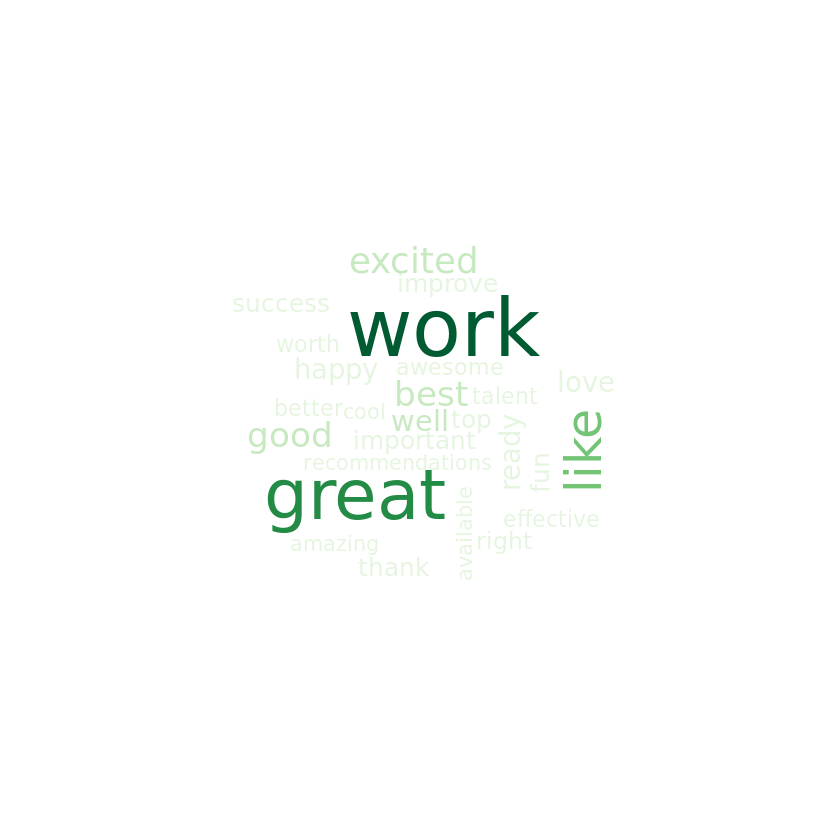

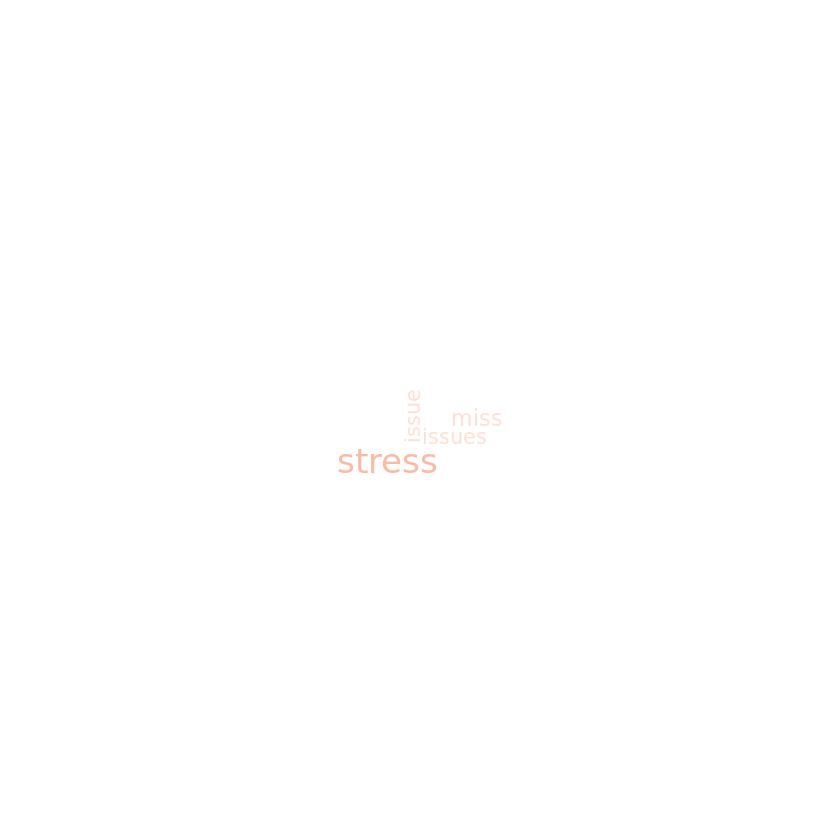

In [317]:
#visualize positive words
positivewordlist<- sentiment_wordlist %>%
filter(sentiment == "positive") 
wordcloud(positivewordlist$word, positivewordlist$count, max.words=30,, colors = brewer.pal(8, "Greens"))

#visualize negative words (but remember, these are much less frequent)
negativewordlist<- sentiment_wordlist %>%
filter(sentiment == "negative") 
wordcloud(negativewordlist$word, positivewordlist$count, max.words=30,, colors = brewer.pal(8, "Reds"))

Now say we want to predict retweets and favorite counts by the words used in a tweet.

In [318]:
tweet_popularity <- mutate(tweets_preprocessed, tweet_popularity = favorite_count + retweet_count) %>%
select(tweet_popularity)

model_data <- cbind(DTM_df, tweet_popularity)

#add in tweet ID number
model_data$ID <- seq.int(nrow(model_data))

#move ID and tweet popularity to front of dataset 
model_data <- select(model_data, ID, tweet_popularity, everything())
head(model_data)


ID,tweet_popularity,also,amazing,annual,another,april,around,article,ask,⋯,work,working,workplace,workshop,world,worth,year,years,youll,youre
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,20,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
6,2,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [319]:
#set seed for reproducibility
set.seed(167)

# let's create a holdout dataset
index <- createDataPartition(model_data$ID, p=0.80, list=FALSE)
training_df <- model_data[index,]
test_df <- model_data[-index,]
# let's set up vectors of algorithms to look at
algo_vec <- c("glmnet","gbm")

# create Kfold index
index <- createFolds(training_df$ID, k=5)
training_df<-training_df[-1] #remove id var
test_df<-test_df[-1] # remove id var


# iterate through analyses and create each model, also validate versus test set
results_df <- data_frame(model=as.character(), validity=as.numeric())
models <- list()
for (j in 1:length(algo_vec)) {
    resultName <- paste0("JP","-",algo_vec[j])
    garbage<-capture.output( #supress output
    models[[resultName]] <- train(  
      tweet_popularity ~ .,
      tuneLength=5,
      data=training_df,
      method=algo_vec[j],
      preProcess=c("zv", "corr"),
      trControl=trainControl(method="cv", number=5, verboseIter=T, index=index)
    )
        )
    results_df <- bind_rows(results_df, data_frame(
      model=resultName,
      validity=cor(predict(models[[resultName]], test_df), pull(test_df, tweet_popularity))
    )
    )
  }

#examine performance
summary(resamples(models))

#examine results
results_df

#examine top 20 vars/model
lapply(models, varImp)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


Call:
summary.resamples(object = resamples(models))

Models: JP-glmnet, JP-gbm 
Number of resamples: 5 

MAE 
              Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
JP-glmnet 5.085179 5.192175 6.454706 6.169801 6.983483 7.133460    0
JP-gbm    5.239552 5.261679 5.376883 5.376467 5.405506 5.598717    0

RMSE 
               Min.   1st Qu.    Median      Mean  3rd Qu.     Max. NA's
JP-glmnet 10.139215 10.166503 12.357870 12.029368 12.39579 15.08746    0
JP-gbm     8.391823  8.916926  9.453622  9.425597 10.14169 10.22392    0

Rsquared 
                  Min.     1st Qu.      Median        Mean     3rd Qu.
JP-glmnet 0.0005800912 0.001259268 0.005147663 0.008084689 0.007118987
JP-gbm              NA          NA          NA         NaN          NA
                Max. NA's
JP-glmnet 0.02631743    0
JP-gbm            NA    5


model,validity
JP-glmnet,0.1090844
JP-gbm,0.1455974


$`JP-glmnet`
glmnet variable importance

  only 20 most important variables shown (out of 204)

              Overall
working       100.000
even           73.979
employee       63.120
article        56.343
evidence       54.111
show           46.526
ready          42.242
people         30.720
best           29.910
cant           28.876
important      21.704
around         19.918
research       18.959
talentmetrics  15.767
students       15.386
learning       12.805
register        9.982
life            9.284
know            7.573
new             5.388

$`JP-gbm`
gbm variable importance

  only 20 most important variables shown (out of 204)

               Overall
new            100.000
people          98.065
students        90.275
research        82.107
psychology      74.476
cant            46.623
help            44.673
organizational  41.748
evidence        39.333
program         25.430
talentmetrics   22.344
register        20.825
best            17.876
science         14.935
career